In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
%matplotlib inline

2025-06-30 09:19:24.418932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751275164.573916      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751275164.620431      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/brain-tumour-dataset/Brain_Tumour_Dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumour-dataset/Brain_Tumour_Dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumour-dataset/Brain_Tumour_Dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumour-dataset/Brain_Tumour_Dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumour-dataset/Brain_Tumour_Dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumour-dataset/Brain_Tumour_Dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumour-dataset/Brain_Tumour_Dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumour-dataset/Brain_Tumour_Dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumour-dataset/Brain_Tumour_Dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumour-dataset/Brain_Tumour_Dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumour-dataset/Brain_Tumour_Dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/in

In [8]:
# Set the path to the dataset
dataset_path = "/kaggle/input/brain-tumour-dataset/Brain_Tumour_Dataset"

# Define the training and testing directories
train_dir = os.path.join(dataset_path, "Training")
test_dir = os.path.join(dataset_path, "Testing")

# Define the categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]


In [9]:
import os

print("Checking dataset path...")
print("✅ Exists!" if os.path.exists(dataset_path) else "❌ Does NOT exist!")


Checking dataset path...
✅ Exists!


In [10]:
print("Checking train and test directories...")
print("Train directory:", "✅ Exists" if os.path.exists(train_dir) else "❌ Missing")
print("Test directory:", "✅ Exists" if os.path.exists(test_dir) else "❌ Missing")


Checking train and test directories...
Train directory: ✅ Exists
Test directory: ✅ Exists


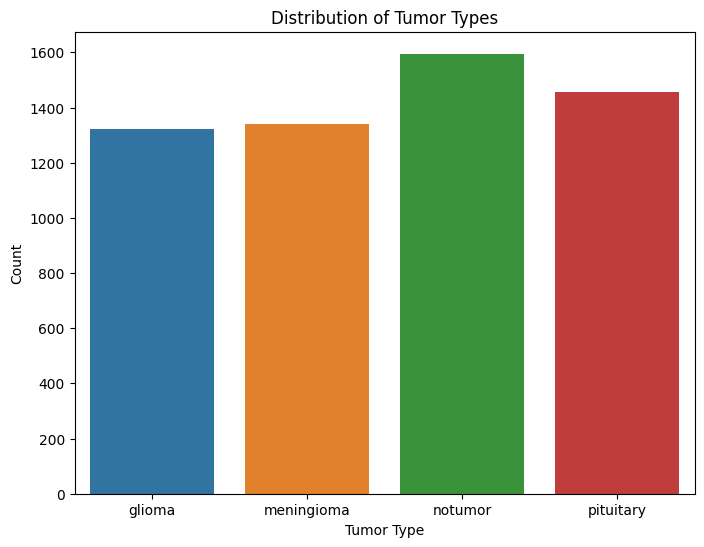

In [11]:
# Load and preprocess the dataset
train_data = []
for category in categories:
    folder_path = os.path.join(train_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

train_df = pd.concat(train_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x="Category", y="Count")
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()


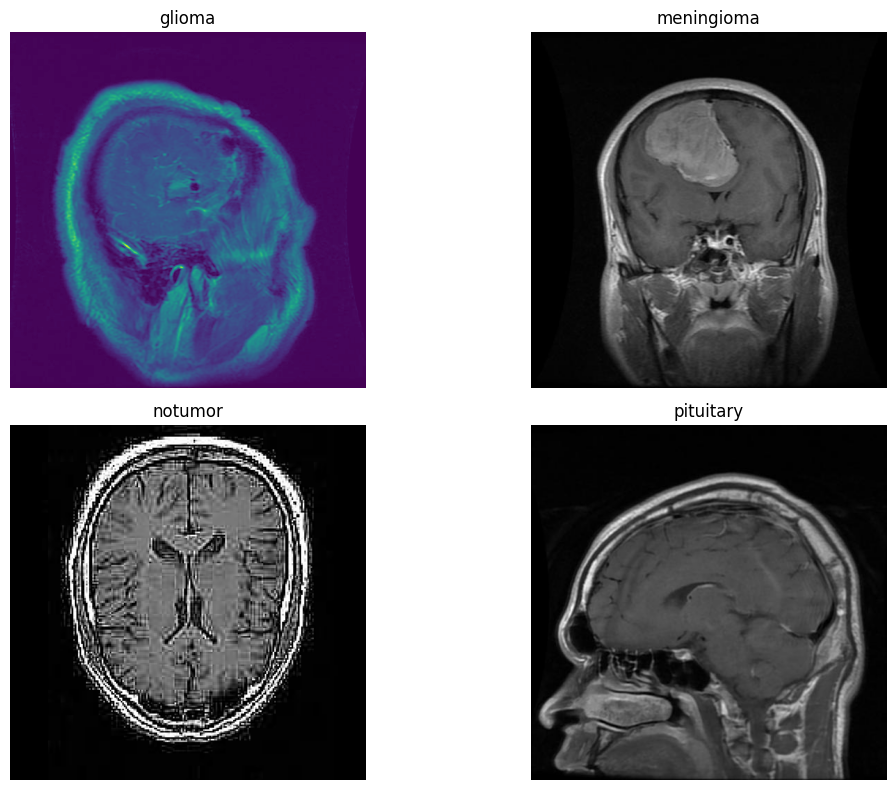

In [14]:
# Visualize sample images for each tumor type
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [16]:
# Set the image size
image_size = (150, 150)

# Set the batch size for training
batch_size = 32

# Set the number of epochs for training
epochs = 60

In [17]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [18]:
# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(len(categories), activation="softmax")
])

# Compile the model
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1751275652.923684      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [19]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60


I0000 00:00:1751275663.011101     113 service.cc:148] XLA service 0x796be000ffa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751275663.011994     113 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751275663.361576     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/178 ━━━━━━━━━━━━━━━━━━━━ 19:19 7s/step - accuracy: 0.3438 - loss: 1.3647

I0000 00:00:1751275666.704783     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


178/178 ━━━━━━━━━━━━━━━━━━━━ 79s 407ms/step - accuracy: 0.5096 - loss: 1.0710 - val_accuracy: 0.6383 - val_loss: 0.9993
Epoch 2/60
  1/178 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6562 - loss: 0.7882

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6562 - loss: 0.7882 - val_accuracy: 0.6000 - val_loss: 1.1457
Epoch 3/60
178/178 ━━━━━━━━━━━━━━━━━━━━ 44s 246ms/step - accuracy: 0.7046 - loss: 0.7526 - val_accuracy: 0.5578 - val_loss: 1.1688
Epoch 4/60
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6875 - loss: 0.7331 - val_accuracy: 0.5516 - val_loss: 1.1854
Epoch 5/60
178/178 ━━━━━━━━━━━━━━━━━━━━ 43s 243ms/step - accuracy: 0.7505 - loss: 0.6344 - val_accuracy: 0.7539 - val_loss: 0.6114
Epoch 6/60
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7188 - loss: 0.6202 - val_accuracy: 0.7594 - val_loss: 0.5766
Epoch 7/60
178/178 ━━━━━━━━━━━━━━━━━━━━ 43s 244ms/step - accuracy: 0.7881 - loss: 0.5370 - val_accuracy: 0.7141 - val_loss: 0.7835
Epoch 8/60
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8438 - loss: 0.3867 - val_accuracy: 0.7125 - val_loss: 0.7982
Epoch 9/60
178/178 ━━━━━━━━━━━━━━━━━━━━ 42s 238ms/step - accuracy: 0.8070 - loss: 0.4896 - val_accurac

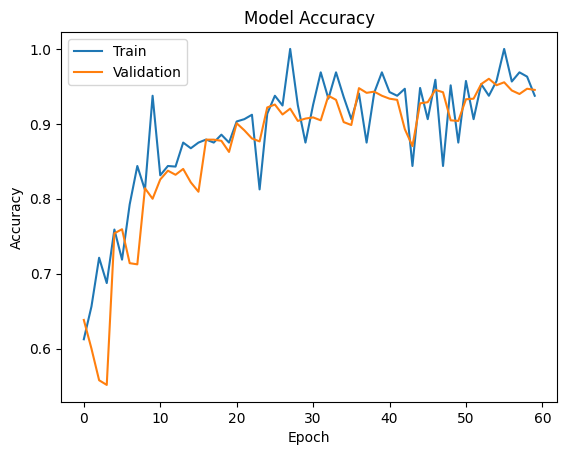

In [20]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

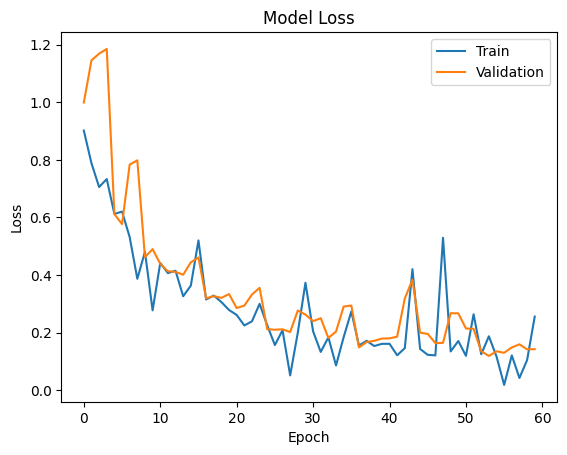

In [21]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [22]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.9087 - loss: 0.2270
Test Loss: 0.14209619164466858
Test Accuracy: 0.9453125


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step


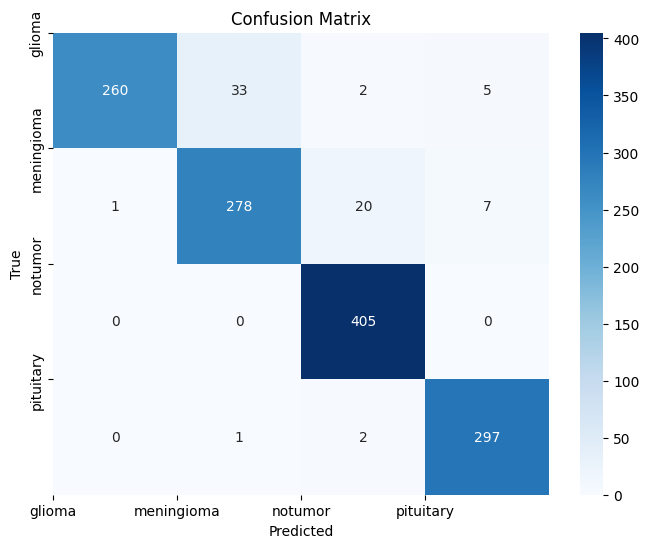

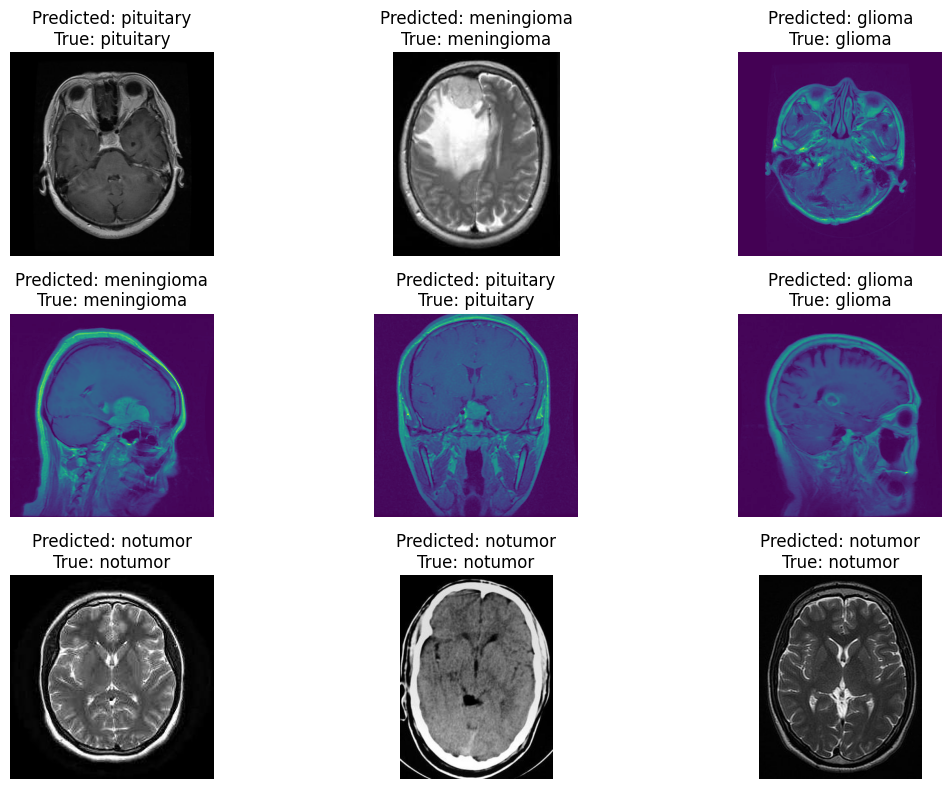

In [23]:
# Make predictions on the test dataset
predictions = model.predict(test_generator)
predicted_categories = np.argmax(predictions, axis=1)
true_categories = test_generator.classes

# Create a confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_categories, predicted_categories)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories)
plt.yticks(ticks=np.arange(len(categories)), labels=categories)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_generator.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


Class: glioma
Precision: 0.9961685823754789
Recall: 0.8666666666666667
F1-Score: 0.9269162210338681

Class: meningioma
Precision: 0.8910256410256411
Recall: 0.9084967320261438
F1-Score: 0.8996763754045308

Class: notumor
Precision: 0.9440559440559441
Recall: 1.0
F1-Score: 0.9712230215827338

Class: pituitary
Precision: 0.9611650485436893
Recall: 0.99
F1-Score: 0.9753694581280788



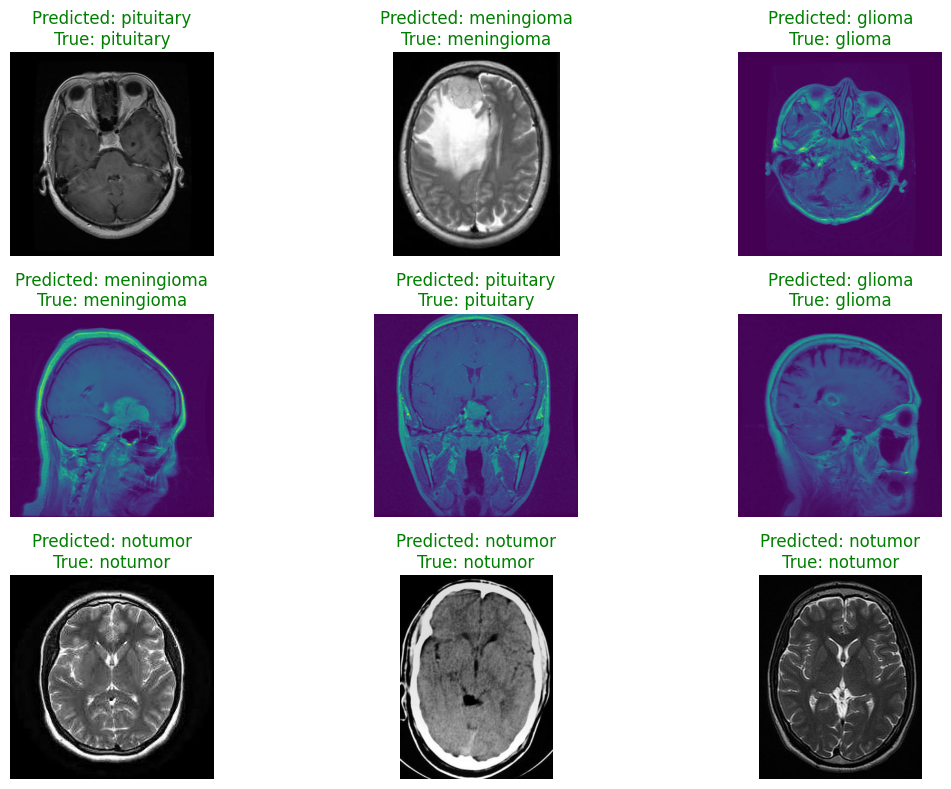

In [24]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1-Score: {f1_score[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions[i] == sample_true_labels[i]:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [25]:
# Save the trained model
model.save('/kaggle/working/my_model.h5')

In [4]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/input/model-tumor/my_model.h5')


2025-06-30 10:15:19.727709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751278519.957052      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751278520.018453      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1751278532.851211      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [2]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 33.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.9/323.9 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.5/95.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 92.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.2 MB/s eta 0:00:00


In [5]:
import gradio as gr
import numpy as np
import cv2


# Class labels (must match training labels)
class_names = ["glioma", "meningioma", "notumor", "pituitary"]

# Preprocessing function
def preprocess_image(img):
    img = cv2.resize(img, (150, 150))  # Resize to model input
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Prediction function with color logic
def predict_tumor(img):
    try:
        img_array = preprocess_image(img)
        preds = model.predict(img_array)[0]
        pred_index = np.argmax(preds)
        pred_label = class_names[pred_index]
        confidence = float(preds[pred_index])

        # If "notumor", use green; otherwise red
        if pred_label == "notumor":
            color = "green"
        else:
            color = "red"

        result = f"<b><span style='color:{color}; font-size:30px;'>Tumor Type: {pred_label} (Confidence: {confidence:.2f})</span></b>"
        return result

    except Exception as e:
        return f"<span style='color:red;'><b>Error in prediction:</b> {str(e)}</span>"

# Gradio Interface
interface = gr.Interface(
    fn=predict_tumor,
    inputs=gr.Image(type="numpy"),
    outputs=gr.HTML(),
    allow_flagging="never",
    title="🧠 Brain Tumor Classifier",
    description="Upload a brain MRI image to detect the type of tumor. The model will classify it as <b>glioma</b>, <b>meningioma</b>, <b>pituitary</b>, or <b>notumor</b>. If a tumor is found, the output will appear in red; otherwise, green.",
)

interface.launch()

/usr/local/lib/python3.11/dist-packages/gradio/interface.py:419: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7861
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://3eb78aef6203d7b691.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


I0000 00:00:1751278555.983285     118 service.cc:148] XLA service 0x7f73bc005350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751278555.984019     118 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751278556.090944     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1751278557.285032     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
